In [1]:
import pandas as pd
import numpy as np
import random
import math
from gravity_utils import *
import json
from datetime import timedelta as td
from datetime import time
from datetime import datetime
from matplotlib.pyplot import plot
from matplotlib import pyplot as plt

import sys
sys.path.insert(1, '../DRTsim')
import sim_utils, const
from sim_utils import Activity, Coord
from const import ActivityType
from shapely.geometry import Point
import shapely.wkt

# Time distribution

In [2]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')

In [3]:
resfil_raw.head()

,Id,Id_time,förfl_nr,lillam,lillan,storaN,Stratum,mätdag,dagtyp,dagtyp_2,...,rf7_km,kl6_km,bostad_storst_småort_landsby,restyp,individvikt,individvikt_svarandemängd,urval_trompNr,rf1_TrompNr,rf4_TrompNr,filter_$
0,1000074.0,10000741.0,1.0,519.0,1608.0,7845.0,27.0,1.0,1.0,1.0,...,11.0,4.0,2.0,2.0,8.330817,0.201277,NaN,NaN,NaN,NaN
1,1000074.0,10000742.0,2.0,519.0,1608.0,7845.0,27.0,1.0,1.0,1.0,...,11.0,4.0,2.0,2.0,8.330817,0.201277,NaN,NaN,NaN,NaN
2,1000116.0,10001161.0,1.0,2118.0,6066.0,25563.0,22.0,1.0,1.0,1.0,...,8.0,3.0,3.0,2.0,22.281823,0.538341,NaN,NaN,NaN,NaN
3,1000116.0,10001162.0,2.0,2118.0,6066.0,25563.0,22.0,1.0,1.0,1.0,...,3.0,2.0,3.0,2.0,22.281823,0.538341,NaN,NaN,NaN,NaN
4,1000116.0,10001163.0,3.0,2118.0,6066.0,25563.0,22.0,1.0,1.0,1.0,...,3.0,2.0,3.0,2.0,22.281823,0.538341,NaN,NaN,NaN,NaN


In [4]:
resfil_raw = resfil_raw.loc[:, ['rf2_starttid','individvikt', 'ärende_2', 'Id', 'rf6_ankomsttid', 'rf7_km']]
#df_resfil = df_resfil[df_resfil['ärende_2']==1]
upsampled_resfil = draw_population(resfil_raw, resfil_raw.individvikt.astype(int))

## Work length distribution

In [5]:
def get_time_distr(resfil_time_int):
    times_binned = pd.cut(resfil_time_int, pd.interval_range(start=0, end=24, freq=0.25, closed='left'))
    time_distribution_raw = times_binned.value_counts().sort_index().values
    return pd.DataFrame(np.convolve(time_distribution_raw, np.ones((4,))/4, mode='same'), \
                          index=times_binned.cat.categories, columns=['total'])

In [6]:
resfil_time_length = resfil_raw[(resfil_raw['ärende_2'] == 1) | (resfil_raw['ärende_2'] == 10)]

In [7]:
resfil_time_length = resfil_time_length.dropna()
resfil_time_length

,rf2_starttid,individvikt,ärende_2,Id,rf6_ankomsttid,rf7_km
5,14:19,22.281823,10.0,1000116.0,15:40,13.0
9,12:30,10.434358,10.0,1000207.0,13:09,30.0
11,16:45,10.434358,10.0,1000207.0,16:55,1.0
16,7:00,93.653602,1.0,1000413.0,7:20,10.0
17,16:00,93.653602,10.0,1000413.0,16:20,10.0
...,...,...,...,...,...,...
56303,20:00,28.950126,10.0,1187400.0,21:00,30.0
56313,15:43,102.874352,10.0,1383249.0,16:30,3.5
56318,18:00,11.837775,10.0,1461201.0,18:20,14.6
56326,17:30,4.394781,10.0,1551902.0,17:40,4.0


In [8]:
resfil_time_length = resfil_time_length.set_index('Id')

In [9]:
resfil_time_length.loc[:, 'rf2_starttid'] = resfil_time_length.rf2_starttid.replace({'99': np.NaN,
                                                                          '18.45': '18:45',
                                                                          '1900-': '19:00',
                                                                          '1 9:4': '19:4'})

resfil_time_length.loc[:, 'rf6_ankomsttid'] = resfil_time_length.rf6_ankomsttid.replace({'99': np.NaN,
                                                                          '18.45': '18:45',
                                                                          '1900-': '19:00',
                                                                          '1 9:4': '19:4'})

resfil_time_length = resfil_time_length.dropna()

In [10]:
d = []
i = []
w = []
for ind in resfil_time_length.index:
    x = resfil_time_length.loc[ind]
    if len(x) > 2:
        continue
    if 10 not in x['ärende_2'].values or 1 not in x['ärende_2'].values:
        continue

    
    start_time = x[x['ärende_2'] == 1]['rf6_ankomsttid']
    end_time = x[x['ärende_2'] == 10]['rf2_starttid']
    
    s = start_time.values[0].split(':')
    start_time = datetime(year = 1970, month = 1 ,day = 1,hour = int(s[0]), minute = int(s[1]))
    
    e = end_time.values[0].split(':')
    end_time = datetime(year = 1970, month = 1 ,day = 1,hour = int(e[0]), minute = int(e[1]))
    
    d.append(abs(end_time - start_time))
    i.append(ind)
    w.append(x['individvikt'].values[0])
work_length = pd.DataFrame(data=[i,d,w])

In [11]:
work_length = work_length.T
work_length.columns = ['Id', 'time', 'weight']

In [12]:
work_length['time_int'] = work_length.time.apply(lambda x: x.seconds / 3600)

In [13]:
upsampled_wl = draw_population(work_length, work_length.weight.astype(int))

In [14]:
work_length_distribution = get_time_distr(upsampled_wl.time_int)

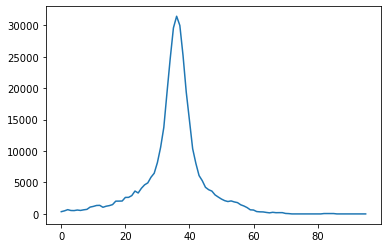

In [15]:
plot(work_length_distribution.total.values)

In [16]:
work_length_distribution.idxmax()

total    [9.0, 9.25)
dtype: object

## trip start distribution

In [17]:
upsampled_resfil.loc[:, 'rf2_starttid'] = upsampled_resfil.rf2_starttid.replace({'99': np.NaN,
                                                                          '18.45': '18:45',
                                                                          '1900-': '19:00',
                                                                          '1 9:4': '19:4'})

upsampled_resfil.loc[:, 'rf6_ankomsttid'] = upsampled_resfil.rf6_ankomsttid.replace({'99': np.NaN,
                                                                          '18.45': '18:45',
                                                                          '1900-': '19:00',
                                                                          '1 9:4': '19:4',
                                                                          '16.40': '16:40',
                                                                            '15.45': '15:45'})
upsampled_resfil = upsampled_resfil.dropna()

In [18]:
upsampled_resfil['s_minute'] = np.NaN
upsampled_resfil['s_hour'] = np.NaN
upsampled_resfil['e_minute'] = np.NaN
upsampled_resfil['e_hour'] = np.NaN

In [19]:
upsampled_resfil['s_time'] = upsampled_resfil.rf2_starttid.astype(str).apply(lambda x: x.split(':')).values
upsampled_resfil['e_time'] = upsampled_resfil.rf6_ankomsttid.astype(str).apply(lambda x: x.split(':')).values

In [20]:
upsampled_resfil.loc[:, ['s_hour']] = upsampled_resfil['s_time'].apply(lambda x: x[0])
upsampled_resfil.loc[:, ['s_hour']] = upsampled_resfil.s_hour.astype(int)
upsampled_resfil.loc[:, ['s_minute']] = upsampled_resfil['s_time'].apply(lambda x: x[1])
upsampled_resfil.loc[:, ['s_minute']] = upsampled_resfil.s_minute.astype(int)
upsampled_resfil.loc[:, ['e_hour']] = upsampled_resfil['e_time'].apply(lambda x: x[0])
upsampled_resfil.loc[:, ['e_hour']] = upsampled_resfil.e_hour.astype(int)
upsampled_resfil.loc[:, ['e_minute']] = upsampled_resfil['e_time'].apply(lambda x: x[1])
upsampled_resfil.loc[:, ['e_minute']] = upsampled_resfil.e_minute.astype(int)

In [21]:
upsampled_resfil['s_time_int'] = upsampled_resfil.s_hour + (upsampled_resfil.s_minute / 60.)
upsampled_resfil['e_time_int'] = upsampled_resfil.e_hour + (upsampled_resfil.e_minute / 60.)

In [22]:
comm_time_distribution = get_time_distr(upsampled_resfil.s_time_int)

In [23]:
comm_time_distribution.head()

,total
"[0.0, 0.25)",636.25
"[0.25, 0.5)",843.50
"[0.5, 0.75)",942.75
"[0.75, 1.0)",864.00
"[1.0, 1.25)",772.00


In [24]:
work_time_distribution = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == 1].e_time_int)
school_time_distribution = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == 2].e_time_int)
home_time_distribution = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == 10].s_time_int)

([<matplotlib.axis.XTick at 0x7f1300e8b7d0>,
 <a list of 7 Text xticklabel objects>)

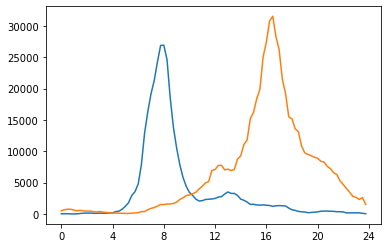

In [25]:
fig = plt.figure()
ax = plt.subplot(111)

#plot(comm_time_distribution.total.values)
plot(work_time_distribution.total.values)
#plot(school_time_distribution.total.values)
plot(home_time_distribution.total.values)

plt.xticks(np.arange(0,97,16), np.arange(0,25,4))

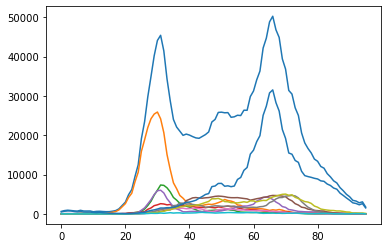

In [26]:
plot(comm_time_distribution.total.values)
for i in range(1,11):
    distr = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == i].s_time_int)
    plot(distr.values)

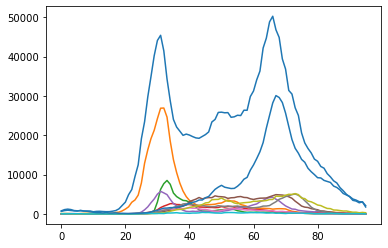

In [27]:
plot(comm_time_distribution.total.values)
for i in range(1,11):
    distr = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == i].e_time_int)
    plot(distr.values)

# The same, but for distance (rf7_km) > 20km

([<matplotlib.axis.XTick at 0x7f12ffad0890>,
 <a list of 7 Text xticklabel objects>)

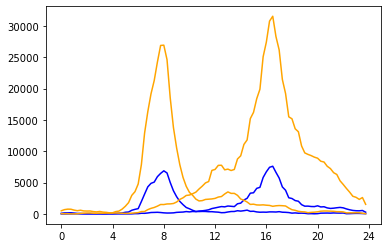

In [28]:
work_time_distribution_long = get_time_distr(upsampled_resfil[(upsampled_resfil['ärende_2'] == 1)&(upsampled_resfil['rf7_km'] >= 30)].e_time_int)
home_time_distribution_long = get_time_distr(upsampled_resfil[(upsampled_resfil['ärende_2'] == 10)&(upsampled_resfil['rf7_km'] >= 30)].s_time_int)

fig = plt.figure()
ax = plt.subplot(111)

plot(work_time_distribution_long.total.values, color='blue')
plot(home_time_distribution_long.total.values, color='blue')
#plot(comm_time_distribution.total.values)
plot(work_time_distribution.total.values, color='orange')
#plot(school_time_distribution.total.values)
plot(home_time_distribution.total.values, color='orange')

plt.xticks(np.arange(0,97,16), np.arange(0,25,4))

# fig = plt.figure()
# ax = plt.subplot(111)
# ax.set_ylabel('number of vehicles')
# ax.set_xlabel('time')
# ax.set_title('Vehicle state by time')
# day_values.plot.area(stacked=True, ax=ax, linewidth=1, color=color_list[len(color_list)-len(day_values.columns):])
# plt.xticks([0, 21600, 43200, 64800, 86400], [0, 6, 12, 18, 24])

# Data preparation

In [29]:
buildings = pd.read_csv('data/GIS/buildings/buildings_zone_codes.csv', sep=';', index_col=0)

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
buildings.head()

,OBJEKT_ID,OBJEKT_VER,DETALJTYP,ADAT,INSAM_LAGE,XYFEL,NAMN1,NAMN2,NAMN3,HUVUDBYGGN,...,ANDAMAL_3,ANDAMAL_4,ANDAMAL_5,ANDAMAL_6,ANDAMAL_7,ANDAMAL_8,ANDAMAL_9,ANDAMAL_10,geometry,zone
0,edd3c338-6f5c-4ccc-a86f-7c9e952a9251,4,HUS,2015-02-26 11:53,3,80,NaN,NaN,NaN,J,...,0,0,0,0,0,0,0,0,POINT (13.32784938676369 55.43775595108503),1287
1,1ecd5c91-ebb9-42a3-9479-bcfc7717f633,6,HUS,2015-08-05 08:53,3,800,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,POINT (13.32720746564975 55.4378811256326),1287
2,a68e9c61-24fe-4097-84f8-6c1b4db5e472,1,HUS,2017-03-07 14:02,1,25,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,POINT (12.8116987415366 55.89962148850962),1282
3,0f486161-9e02-47e3-90d5-e363f1dc1743,4,HUS,2017-05-18 08:42,1,100,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,POINT (13.6062885260532 56.1554668437222),1293
4,165d326f-4430-44d2-9263-2afb0b1a7e8b,1,HUS,2011-03-22 07:28,3,25,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,POINT (13.40628403801613 55.5997678719453),1281


In [31]:
od_matrix = pd.read_csv('data/od_vehits_kommun_based', index_col=0)
od_matrix.head()

,1214,1230,1231,1233,1256,1257,1260,1261,1262,1263,...,12700011,12700012,12700013,12700014,12700015,12700016,12700017,12700018,12700019,12700020
1214,473,2,2,9,7,5,73,126,31,3,...,0,0,0,0,0,0,0,0,0,0
1230,1,116,104,18,2,3,1,48,22,18,...,0,0,0,0,0,0,0,0,0,0
1231,0,67,132,14,2,1,1,33,154,13,...,0,0,0,0,0,0,0,0,0,0
1233,6,47,60,3128,18,22,9,8,84,47,...,0,0,0,0,0,0,0,0,0,0
1256,5,4,5,27,1538,5,4,15,5,5,...,0,0,0,0,0,0,0,0,0,0


# Assigning building's position for persons

In [32]:
origin = od_matrix.index[0]
destination = int(od_matrix.loc[origin].sample(1, weights=od_matrix.loc[origin].values).index[0])
origin_buildings = buildings[buildings.zone == origin]
destionation_buildings = buildings[buildings.zone == destination]

In [33]:
class Population:
    def __init__(self):
        self.persons = []
    def to_JSON(self):
        return json.dumps(self, default=lambda o: _try(o), sort_keys=True, indent=4, separators=(',',':'))


class Person:
    def __init__(self):
        self.activities = []
        
#    def toJSON(self):
#        return json.dumps(self, default=lambda o: o.__dict__, 
#            sort_keys=True, indent=4)
        
#     def to_JSON(self):
#         return json.dumps(self, default=lambda o: _try(o), sort_keys=True, indent=4, separators=(',',':'))
        
def _try(o):
    try:
        if o.__class__ == ActivityType:
            raise Exception()
        return o.__dict__
    except:
        return str(o)

from enum import Enum
class ActivityType(Enum):
    HOME = 'HOME'
    WORK = 'WORK'

    def __str__(self):
        return self.name
    
class Activity(object):
    """Activity that is performed by a person.
    Person moves to a next activity after end_time is reached.

    Parameters
    ----------
    type_ : <ActivityType>
    coord : <Coord>
    start_time : <int> seconds from 00:00
    end_time : <int> seconds from 00:00
    """

    def __init__(self, type_, coord, start_time=None, end_time=None, zone=None):
        """docstring"""
        if start_time is None and end_time is None:
            raise Exception("Sanity check: both activity times are None")
        self.type = type_
        self.coord = coord
        self.start_time = start_time
        self.end_time = end_time
        self.zone = zone

    def __str__(self):
        return 'An ' + str(self.type) + ' at ' + str(self.coord)

In [34]:
def form_datetime(x):
    if type(x) == np.float64:
        m = (x - math.trunc(x)) * 60
        s = math.trunc((m - math.trunc(m)) * 60)
        m = math.trunc(m)
        h = math.trunc(x)
        return datetime(year = 1970, month = 1 ,day = 1, hour = h, minute=m, second = s)
    elif type(x) == time:
        return datetime(year = 1970, month = 1 ,day = 1, hour = x.hour, minute=x.minute, second = x.second)
    
def form_td(x):
    if type(x) == np.float64:
        m = (x - math.trunc(x)) * 60
        s = math.trunc((m - math.trunc(m)) * 60)
        m = math.trunc(m)
        h = math.trunc(x)
        return td(hours = h, minutes=m, seconds = s)
    elif type(x) == time:
        return td(hours = x.hour, minutes=x.minute, seconds = x.second)

In [35]:
datetime(year = 1970, month = 1 ,day = 1, hour = 23) + td(minutes=90)

datetime.datetime(1970, 1, 2, 0, 30)

In [36]:
a = datetime(year = 1970, month = 1 ,day = 1, hour = 23)
b = td(minutes=90)
(a + b).date()

datetime.date(1970, 1, 2)

In [37]:
datetime(year = 1970, month = 1 ,day = 1, hour = 1).time() < time(1,30)

True

# Main cycle

In [89]:
work_time_distribution.iloc[12*4:24*4] = 0

([<matplotlib.axis.XTick at 0x7f12e8bcecd0>,
 <a list of 7 Text xticklabel objects>)

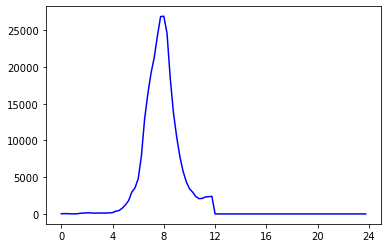

In [90]:
fig = plt.figure()
ax = plt.subplot(111)

plot(work_time_distribution.total.values, color='blue')

plt.xticks(np.arange(0,97,16), np.arange(0,25,4))

In [91]:
population = Population()

def sample_time(time_distr):
    time_bin = time_distr.sample(1, weights='total').index
    return form_datetime(random.uniform(time_bin.left, time_bin.right)[0]).time()

def form_activity(zone, act_type, coord=None, buildings=None, s_time=None, s_distr=None, e_time=None, e_distr=None, l_distr=None):
    """Combines an activity out of provided locations, type and times
    
    Parameters
    ----------
    coord, buildings: exact coordinate or pd.Dataframe of buildings
    s_time, s_distr: starting time or time distribution.
    e_time, e_distr: end time or distribution.
    l_distr: distribution of activity duration. Added to start time
    """
    if coord is not None:
        location = coord
    else:
        coord = shapely.wkt.loads(buildings.sample(1).geometry.values[0])
        location = Coord(lat=coord.y, lon=coord.x)
    
    if s_time is not None:
        start_time = s_time
    else:
        start_time = sample_time(s_distr)
        
    if e_time is not None:
        end_time = e_time
    elif l_distr is not None:
        end_time_tmp = form_datetime(start_time) + form_td(sample_time(l_distr))
        if end_time_tmp.date() != form_datetime(start_time).date():
            end_time = time(23,59,59)
        else:
            end_time = end_time_tmp.time()
    else:
        end_time = sample_time(e_distr)
        
    return Activity(act_type,
                   location,
                   start_time=start_time,
                   end_time=end_time,
                   zone=zone
                  )

sjobo = np.arange(12650000,12650020)

for origin, destinations in od_matrix.iterrows():
    
    for destination, pop in destinations.iteritems():
        # only calculate persons that go to, from or within target zones         
        if (int(origin) not in sjobo) and \
            (int(destination) not in sjobo):
            continue
        #destination = int(destinations.sample(1, weights=destinations.values).index[0])
        origin_buildings = buildings[buildings.zone == origin]
        destionation_buildings = buildings[buildings.zone == int(destination)]
        
        print(origin, destination, round(pop))
        for pers in range(round(pop)):
            new_pers = Person()
            
            # home activity
            act = form_activity(buildings = origin_buildings, 
                                zone =origin, 
                                act_type = ActivityType.HOME,
                                s_time = time(0),
                                e_distr = work_time_distribution)          
            new_pers.activities.append(act)
            
            # work activity            
            act = form_activity(buildings = destionation_buildings, 
                    zone = destination, 
                    act_type = ActivityType.WORK,
                    s_time = new_pers.activities[-1].end_time,
#                     l_distr = work_length_distribution
                    e_distr = home_time_distribution            
                    )
            # make sure work is not in the same place
            while act.coord == new_pers.activities[-1].coord or act.start_time < new_pers.activities[-1].end_time or\
                  act.start_time > act.end_time:
                act = form_activity(buildings = destionation_buildings, 
                    zone = int(destination), 
                    act_type = ActivityType.WORK,
                    s_time = new_pers.activities[-1].end_time,
#                     l_distr = work_length_distribution
                    e_distr = home_time_distribution
                    )
            new_pers.activities.append(act)
            
            # back home activity
            act = form_activity(coord = new_pers.activities[0].coord, 
                    zone = origin, 
                    act_type = ActivityType.HOME,
                    s_time = new_pers.activities[-1].end_time,
                    e_time = time(23,59,59))
            new_pers.activities.append(act)
            
            population.persons.append(new_pers)
            

#        print(origin, destination, round(pop))
            
#        break
#    break
    

1214 12650001 0
1214 12650002 0
1214 12650003 0
1214 12650004 0
1214 12650005 0
1214 12650006 0
1214 12650007 0
1214 12650008 0
1214 12650009 0
1214 12650010 0
1214 12650011 0
1214 12650012 0
1214 12650013 0
1214 12650014 0
1214 12650015 0
1214 12650016 0
1214 12650017 0
1230 12650001 0
1230 12650002 0
1230 12650003 0
1230 12650004 0
1230 12650005 0
1230 12650006 0
1230 12650007 0
1230 12650008 0
1230 12650009 0
1230 12650010 0
1230 12650011 0
1230 12650012 0
1230 12650013 0
1230 12650014 0
1230 12650015 0
1230 12650016 0
1230 12650017 0
1231 12650001 0
1231 12650002 0
1231 12650003 0
1231 12650004 0
1231 12650005 0
1231 12650006 0
1231 12650007 0
1231 12650008 0
1231 12650009 0
1231 12650010 0
1231 12650011 0
1231 12650012 0
1231 12650013 0
1231 12650014 0
1231 12650015 0
1231 12650016 0
1231 12650017 0
1233 12650001 0
1233 12650002 0
1233 12650003 0
1233 12650004 0
1233 12650005 0
1233 12650006 0
1233 12650007 0
1233 12650008 0
1233 12650009 0
1233 12650010 0
1233 12650011 0
1233 126

1293 12650014 0
1293 12650015 0
1293 12650016 0
1293 12650017 0
12650001 1214 0
12650001 1230 2
12650001 1231 4
12650001 1233 1
12650001 1256 1
12650001 1257 1
12650001 1260 1
12650001 1261 1
12650001 1262 0
12650001 1263 0
12650001 1264 5
12650001 1266 2
12650001 1267 4
12650001 1272 1
12650001 1273 2
12650001 1275 1
12650001 1276 0
12650001 1277 1
12650001 1278 2
12650001 1280 86
12650001 1281 28
12650001 1282 1
12650001 1283 4
12650001 1284 1
12650001 1285 1
12650001 1286 17
12650001 1287 2
12650001 1290 4
12650001 1291 0
12650001 1292 2
12650001 1293 2
12650001 12650001 0
12650001 12650002 0
12650001 12650003 18
12650001 12650004 26
12650001 12650005 32
12650001 12650006 0
12650001 12650007 4
12650001 12650008 5
12650001 12650009 8
12650001 12650010 0
12650001 12650011 0
12650001 12650012 0
12650001 12650013 0
12650001 12650014 10
12650001 12650015 0
12650001 12650016 0
12650001 12650017 3
12650001 12700001 0
12650001 12700002 0
12650001 12700003 0
12650001 12700004 0
12650001 1270

12650007 12650009 0
12650007 12650010 0
12650007 12650011 0
12650007 12650012 0
12650007 12650013 0
12650007 12650014 0
12650007 12650015 13
12650007 12650016 0
12650007 12650017 0
12650007 12700001 0
12650007 12700002 0
12650007 12700003 0
12650007 12700004 0
12650007 12700005 0
12650007 12700006 0
12650007 12700007 0
12650007 12700008 0
12650007 12700009 0
12650007 12700010 0
12650007 12700011 0
12650007 12700012 0
12650007 12700013 0
12650007 12700014 0
12650007 12700015 0
12650007 12700016 0
12650007 12700017 0
12650007 12700018 0
12650007 12700019 0
12650007 12700020 0
12650008 1214 0
12650008 1230 3
12650008 1231 4
12650008 1233 2
12650008 1256 1
12650008 1257 1
12650008 1260 1
12650008 1261 1
12650008 1262 0
12650008 1263 3
12650008 1264 4
12650008 1266 5
12650008 1267 0
12650008 1272 1
12650008 1273 2
12650008 1275 1
12650008 1276 1
12650008 1277 1
12650008 1278 2
12650008 1280 121
12650008 1281 41
12650008 1282 1
12650008 1283 6
12650008 1284 2
12650008 1285 1
12650008 1286 18

12650014 1267 6
12650014 1272 1
12650014 1273 2
12650014 1275 1
12650014 1276 1
12650014 1277 1
12650014 1278 3
12650014 1280 12
12650014 1281 77
12650014 1282 2
12650014 1283 8
12650014 1284 1
12650014 1285 19
12650014 1286 8
12650014 1287 3
12650014 1290 5
12650014 1291 1
12650014 1292 3
12650014 1293 3
12650014 12650001 4
12650014 12650002 0
12650014 12650003 23
12650014 12650004 33
12650014 12650005 40
12650014 12650006 3
12650014 12650007 1
12650014 12650008 0
12650014 12650009 6
12650014 12650010 0
12650014 12650011 6
12650014 12650012 10
12650014 12650013 3
12650014 12650014 13
12650014 12650015 8
12650014 12650016 5
12650014 12650017 3
12650014 12700001 0
12650014 12700002 0
12650014 12700003 0
12650014 12700004 0
12650014 12700005 0
12650014 12700006 0
12650014 12700007 0
12650014 12700008 0
12650014 12700009 0
12650014 12700010 0
12650014 12700011 0
12650014 12700012 0
12650014 12700013 0
12650014 12700014 0
12650014 12700015 0
12650014 12700016 4
12650014 12700017 0
12650014

12700011 12650007 0
12700011 12650008 0
12700011 12650009 0
12700011 12650010 0
12700011 12650011 5
12700011 12650012 0
12700011 12650013 0
12700011 12650014 0
12700011 12650015 0
12700011 12650016 0
12700011 12650017 0
12700012 12650001 0
12700012 12650002 0
12700012 12650003 3
12700012 12650004 3
12700012 12650005 3
12700012 12650006 0
12700012 12650007 0
12700012 12650008 0
12700012 12650009 0
12700012 12650010 0
12700012 12650011 5
12700012 12650012 0
12700012 12650013 0
12700012 12650014 0
12700012 12650015 0
12700012 12650016 0
12700012 12650017 0
12700013 12650001 0
12700013 12650002 0
12700013 12650003 0
12700013 12650004 0
12700013 12650005 0
12700013 12650006 0
12700013 12650007 0
12700013 12650008 0
12700013 12650009 0
12700013 12650010 0
12700013 12650011 0
12700013 12650012 5
12700013 12650013 3
12700013 12650014 0
12700013 12650015 0
12700013 12650016 0
12700013 12650017 0
12700014 12650001 0
12700014 12650002 0
12700014 12650003 0
12700014 12650004 0
12700014 12650005 4


In [92]:
j = json.loads(population.to_JSON())

In [93]:
len(j.get('persons'))

8083

In [94]:
outgoing = 0
incomming = 0
within = 0
sjobo = [z for z in range(12650000, 12650019)]
for person in j['persons']:
    szone = int(person['activities'][0]['zone'])
    ezone = int(person['activities'][1]['zone'])
    
    if szone in sjobo and ezone in sjobo:
        within += 1
    elif szone in sjobo and ezone not in sjobo:
        outgoing += 1
    else:
        incomming += 1

In [95]:
print (outgoing, incomming, within)

3832 2088 2163


In [96]:
for person in j.get('persons'):
    s_time = datetime.strptime(person['activities'][0]['end_time'], '%H:%M:%S')
    e_time = datetime.strptime(person['activities'][1]['end_time'], '%H:%M:%S')
    if (e_time - s_time).total_seconds() < 0:
        print('ERROR! end time of activity is earlier than end!')
        print(s_time, e_time)

In [97]:
with open('data/population_from_VEHITS_kommun_od_cut_work_distr.json', 'w') as outfile:
    json.dump(j, outfile)